In [1]:
#@title Imports
import requests, os, zipfile
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from tqdm import tqdm
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import copy
from collections import namedtuple
import random
import shutil
import time

# Path to the events archive
dataset_zip = '/tmp/combined.zip'

# Path to the extracted events
dataset_dir = '/tmp/dataset/'

# Path to the dataset file
dataset_pkl = '/tmp/dataset.zip'

# Path to the model
model_path = '/tmp/'

In [2]:
#@title Dataset Download

import requests, os, zipfile

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Download the dataset combined
#download_file_from_google_drive('1XbECYqiqKzlBOsd7DfhK9LwXV1rSmNUD', dataset_zip)
download_file_from_google_drive('1Nz0WQToBpYTv2j4xWxF5YNonMmRQ2vok', dataset_zip)
# Unzip the dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

In [3]:
# Paths to event files
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [4]:
#@title Print Dataset Statistics


train_images = glob.glob(os.path.join(train_dir,'*', '*.jpg'))
validation_images = glob.glob(os.path.join(validation_dir,'*', '*.jpg'))
test_images = glob.glob(os.path.join(test_dir,'*', '*.jpg'))

train_classes = [os.path.basename(os.path.dirname(x)) for x in train_images]
validation_classes = [os.path.basename(os.path.dirname(x)) for x in validation_images]
test_classes = [os.path.basename(os.path.dirname(x)) for x in test_images]

assert len(set(train_classes))==len(set(validation_classes)), 'Class mismatch between train and val'
classes = set(train_classes)
num_classes = len(classes)

for class_ in classes:
  print('Class {}: training images: {}, test images: {}, validation images: {}'.format(class_, train_classes.count(class_), test_classes.count(class_), validation_classes.count(class_)))
print('\nTotal training images:', len(train_images))
print('Total test images:', len(test_images))
print('Total validation images:', len(validation_images))

print('Number of classes:', num_classes)

Class GL: training images: 1486, test images: 188, validation images: 185
Class HE: training images: 2650, test images: 333, validation images: 330

Total training images: 4136
Total test images: 521
Total validation images: 515
Number of classes: 2


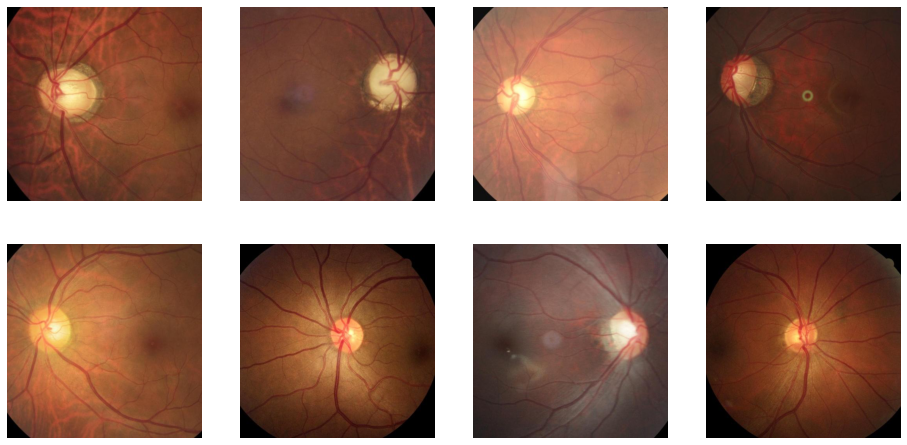

In [5]:
#@title Plot images
% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = num_classes
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for row, class_ in enumerate(classes):
  class_images = [img for img,label in zip(validation_images, validation_classes) if label==class_]
  for col in range(ncols):
    sp = plt.subplot(nrows, ncols, row*ncols+col+1)
    sp.axis('Off')
    img = mpimg.imread(class_images[col])
    plt.imshow(img)
    
plt.show()

In [6]:
#@title Define transforms for the training, validation, and testing sets
pretrained_size = 224
pretrained_means =  [0.4894, 0.2924, 0.1910] #[0.485, 0.456, 0.406]
pretrained_stds= [0.1567, 0.1097, 0.0697] #[0.229, 0.224, 0.225]

training_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

testing_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

validation_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])
BATCH_SIZE = 64
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(validation_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=BATCH_SIZE)

In [7]:
#@title Mean and std calculation
# train_data = datasets.ImageFolder(root = train_dir, 
#                                   transform = transforms.ToTensor())

# means = torch.zeros(3)
# stds = torch.zeros(3)

# for img, label in train_data:
#     means += torch.mean(img, dim = (1,2))
#     stds += torch.std(img, dim = (1,2))

# means /= len(train_data)
# stds /= len(train_data)
    
# print(f'Calculated means: {means}')
# print(f'Calculated stds: {stds}')

In [8]:
#@title Image functions
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    


def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        #ax.set_title(label)
        ax.axis('off')

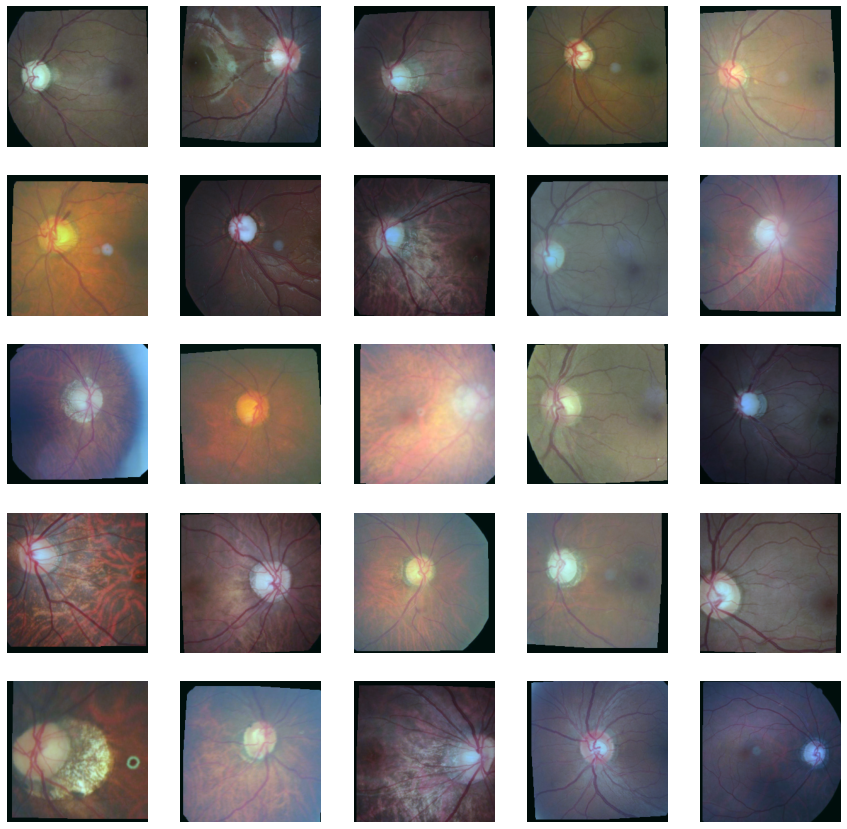

In [9]:
#@title Preprocessed images print
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [training_dataset[i] for i in range(N_IMAGES)]])

classes = testing_dataset.classes

plot_images(images, labels, classes)

In [10]:
labels_map = {
    0: "HE",
    1: "GL",
}
train_features, train_labels = next(iter(test_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
img.size()

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


torch.Size([3, 224, 224])

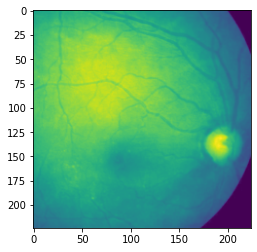

Label: 0


In [11]:

label = train_labels[0]
plt.imshow((torch.squeeze(img[0])))
plt.show()
print(f"Label: {label}")

In [12]:
 torch.cuda.is_available() 

True

In [13]:
#@title Model print
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=False)

IN_FEATURES = model.fc.in_features 
OUTPUT_DIM = 2

fc =  nn.Linear(IN_FEATURES, OUTPUT_DIM)

model.fc = fc
LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
#@title Accuracy function
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [15]:
#@title Validation function
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [16]:
EPOCHS = 60
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH


In [17]:
#@title Train function
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for x, y in iterator:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()

        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [18]:
#@title Evaluation function
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
train_accu = []
train_losses = []
eval_losses=[]
eval_accu=[]

In [21]:
#@title Training
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, test_loader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_accu.append(train_acc_1)
    train_losses.append(train_loss)
    eval_losses.append(valid_loss)
    eval_accu.append(valid_acc_1)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}%')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01 | Epoch Time: 2m 6s
	Train Loss: 0.642 | Train Acc @1:  72.44%
	Valid Loss: 0.603 | Valid Acc @1:  71.33%
Epoch: 02 | Epoch Time: 2m 6s
	Train Loss: 0.443 | Train Acc @1:  79.57%
	Valid Loss: 0.897 | Valid Acc @1:  79.40%
Epoch: 03 | Epoch Time: 2m 6s
	Train Loss: 0.417 | Train Acc @1:  81.30%
	Valid Loss: 0.474 | Valid Acc @1:  82.27%
Epoch: 04 | Epoch Time: 2m 6s
	Train Loss: 0.392 | Train Acc @1:  82.61%
	Valid Loss: 2.330 | Valid Acc @1:  77.18%
Epoch: 05 | Epoch Time: 2m 5s
	Train Loss: 0.380 | Train Acc @1:  82.92%
	Valid Loss: 0.416 | Valid Acc @1:  81.04%
Epoch: 06 | Epoch Time: 2m 6s
	Train Loss: 0.371 | Train Acc @1:  83.30%
	Valid Loss: 0.474 | Valid Acc @1:  75.56%
Epoch: 07 | Epoch Time: 2m 6s
	Train Loss: 0.353 | Train Acc @1:  84.05%
	Valid Loss: 0.397 | Valid Acc @1:  77.49%
Epoch: 08 | Epoch Time: 2m 6s
	Train Loss: 0.334 | Train Acc @1:  84.74%
	Valid Loss: 0.407 | Valid Acc @1:  82.08%
Epoch: 09 | Epoch Time: 2m 6s
	Train Loss: 0.329 | Train Acc @1:  85.58%

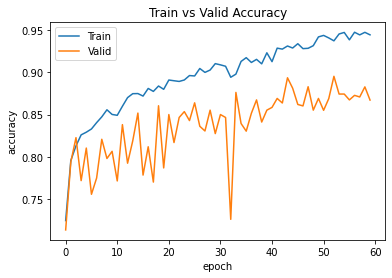

In [22]:
#@title Plot Train vs Valid Accuracy
plt.plot(train_accu,'-')
plt.plot(eval_accu,'-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

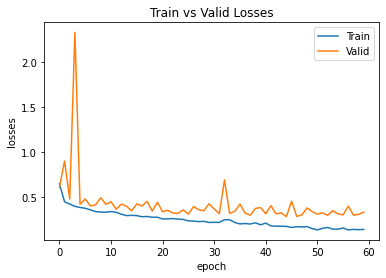

In [23]:
#@title Plot Train vs Valid Losses
plt.plot(train_losses,'-')
plt.plot(eval_losses,'-')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

In [24]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [25]:
images, labels, probs = get_predictions(model, validate_loader)

In [26]:
pred_labels = torch.argmax(probs, 1)

In [27]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels, normalize='true')
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot( cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

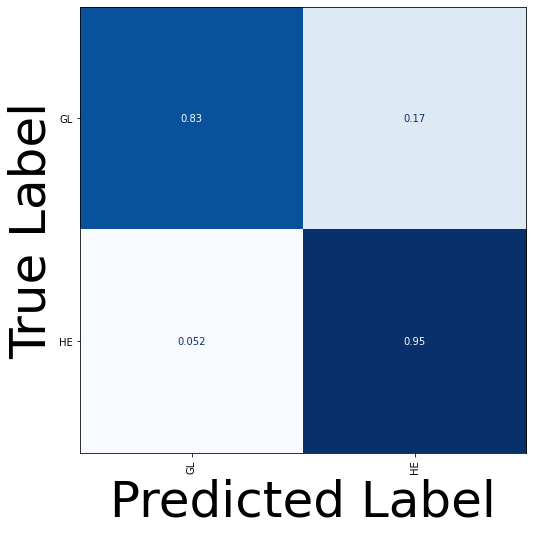

In [28]:
plot_confusion_matrix(labels, pred_labels, classes)

In [29]:
accuracy_score(labels, pred_labels)

0.9067961165048544

In [33]:
model_folder = glob.glob(os.path.join(model_path))
torch.save(model.state_dict(), model_folder[0]+"bn_60_epochs.pt")


In [31]:
# Model with resnet arch 25 epochs
#download_file_from_google_drive('1jIib6Gl2EcmzVLsVw_xm6kjERlIIV03R', '/tmp/state_dict_model.pt')


In [34]:
loaded_model = models.resnet50(pretrained=False)
IN_FEATURES = loaded_model.fc.in_features
OUTPUT_DIM = len(testing_dataset.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
loaded_model.fc = fc

loaded_model.load_state_dict(torch.load('/tmp/bn_60_epochs.pt'))
#loaded_model.load_state_dict(torch.load('/content/state_dict_model.pt'))
loaded_model.to(device)
loaded_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
images, labels, probs = get_predictions(loaded_model, validate_loader)
pred_labels = torch.argmax(probs, 1)
accuracy_score(labels, pred_labels)

0.9067961165048544